* 현재: rslt_all.num_total_epoch == 30인 경우만 LSTM 모델에 handcrafted_feature를 활용한 것.

* 나머지 epoch의 경우 LSTM 모델에 handcrafted features가 들어가지 않았음, 그리고 history visit의 케이스일 때, label도 가장 최신 걸로 되어 있었음 (오류)

* 따라서 현재는 epoch == 30일 때의 결과가 가장 믿을 수 있음, epoch = 25, 50, 200일 때의 결과는 경향성은 비슷하나 완전하지 않은 세팅임.

In [8]:
import pandas as pd
import csv 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import glob

In [9]:
rslt_all = pd.read_csv('../results/all/all_results.csv')
rslt_all = rslt_all[(rslt_all.num_total_epoch == 30)]  # (rslt_all.c_nll_date == 0.015625) & 
print(rslt_all.shape)
rslt_all = rslt_all.sort_values(by=['store_id', 'all_data'])
rslt_all[rslt_all.all_data == False].groupby(['store_id', 'all_data', 'previous_visits']).apply(len)
# rslt_all[rslt_all.all_data == False].groupby(['store_id', 'all_data', 'previous_visits'])['exp_id'].apply(print)

(35, 55)


store_id  all_data  previous_visits
store_A   False     False              1
                    True               2
store_B   False     False              4
                    True               4
store_C   False     False              4
                    True               4
store_D   False     False              4
                    True               4
store_E   False     False              4
                    True               4
dtype: int64

### Train loss & Test metrics to check overfitting

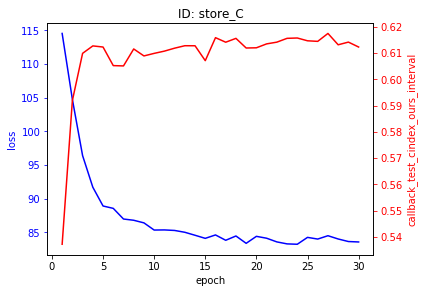

In [3]:
def getID(store_id, previous_visits, all_data=False):
    ids = set(rslt_all[(rslt_all.all_data == all_data) & (rslt_all.store_id == store_id) & (rslt_all.previous_visits == previous_visits)].exp_id)
#     return np.random.choice(list(ids), size=1)
    return ids

def scorebyepoch(inputIDs, metric):
    """
    Parameter:
    inputIDs: ID to check
    metric: metric to check
    """
    file_true = ['../results/callback/{}.csv'.format(id) for id in inputIDs]
    dfl = []
    for cfile in file_true:
        rslt_cb = pd.read_csv(cfile)
        dfl.append(rslt_cb)
    rsltc = pd.concat(dfl)
    return rsltc.groupby(['epoch'])[metric].apply(np.mean)

def draw_plot_train_test(store_id, previous_visits, metric1, metric2):
    ids = getID(store_id=store_id,previous_visits=previous_visits,all_data=False)
    
    fig, ax1 = plt.subplots()
    y1 = scorebyepoch(ids, metric1)
    t = np.array(y1.index)
    ax1.plot(t, y1, 'b-')
    ax1.set_xlabel('epoch')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel(metric1, color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    y2 = scorebyepoch(ids, metric2)
    t = np.array(y2.index)
    ax2.plot(t, y2, 'r-')
    ax2.set_ylabel(metric2, color='r')
    ax2.tick_params('y', colors='r')

    fig.tight_layout()
    plt.title('ID: '+ store_id);
    plt.show()
    
draw_plot_train_test(store_id='store_C', previous_visits=False, metric1='loss', metric2='callback_test_cindex_ours_interval')

### Using Histories or Not via LSTM
* No LSTM is better

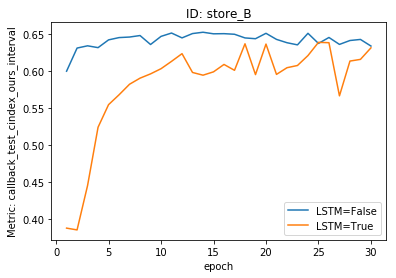

<Figure size 432x288 with 0 Axes>

In [4]:
def getID(store_id, previous_visits, all_data=False):
    ids = set(rslt_all[(rslt_all.all_data == all_data) & (rslt_all.store_id == store_id) & (rslt_all.previous_visits == previous_visits)].exp_id)
    return ids

def scorebyepoch(inputIDs, metric):
    """
    Parameter:
    inputIDs: ID to check
    metric: metric to check
    """
    file_true = ['../results/callback/{}.csv'.format(id) for id in inputIDs]
    dfl = []
    for cfile in file_true:
        rslt_cb = pd.read_csv(cfile)
        dfl.append(rslt_cb)
    rsltc = pd.concat(dfl)
    return rsltc.groupby(['epoch'])[metric].apply(np.mean)

def draw_plot(store_id, metric):
    falseID = getID(store_id=store_id,previous_visits=False,all_data=False)
    trueID = getID(store_id=store_id,previous_visits=True,all_data=False)
    scorebyepoch(falseID, metric).plot()
    scorebyepoch(trueID, metric).plot()
#     plt.xticks([0,5,10,15,20,25])
    plt.title('ID: '+ store_id);
    plt.xlabel('epoch');
    plt.ylabel('Metric: {}'.format(metric));
    plt.legend(['LSTM=False', 'LSTM=True']);
    plt.figure(clear=True)
    
draw_plot(store_id='store_B', metric='callback_test_cindex_ours_interval')   # loss

/home/dmlab/ksedm1/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


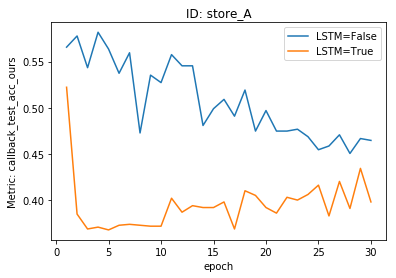

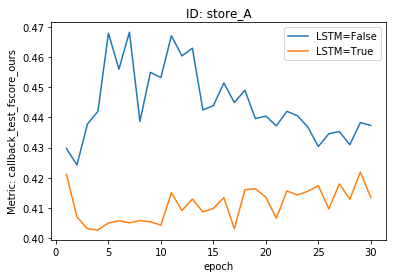

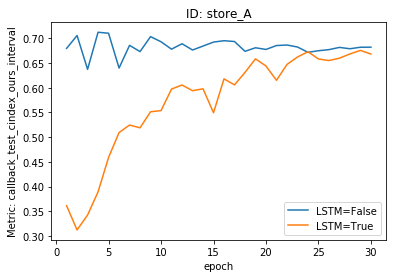

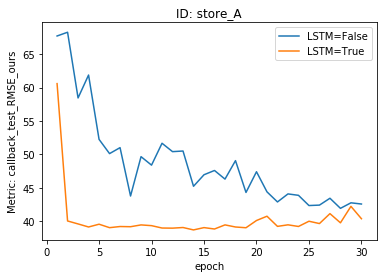

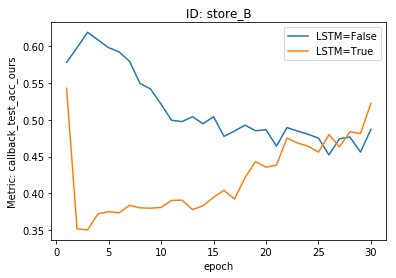

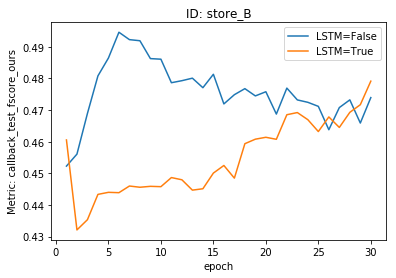

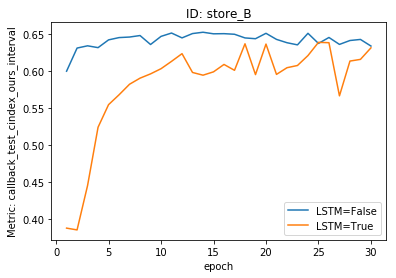

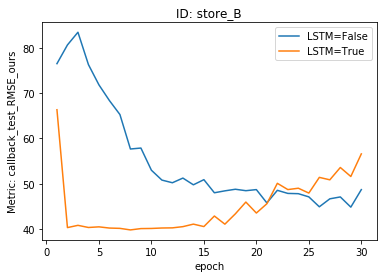

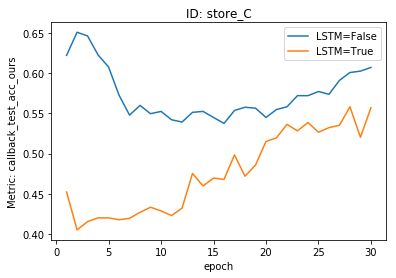

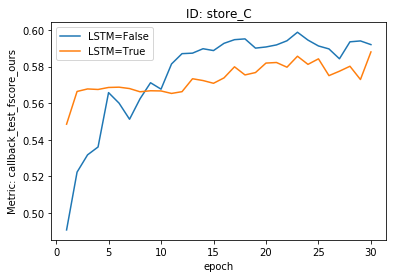

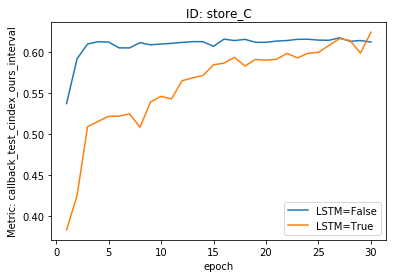

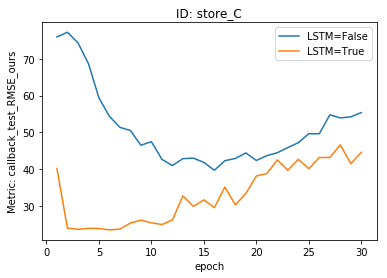

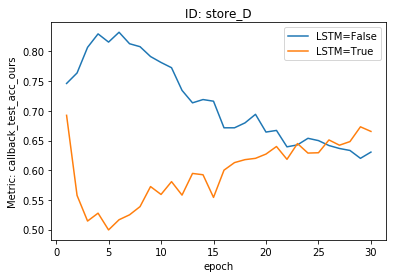

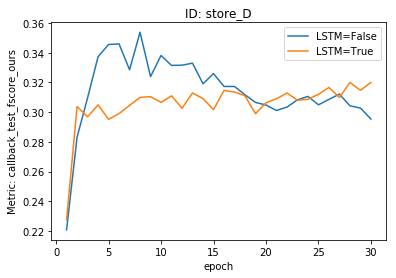

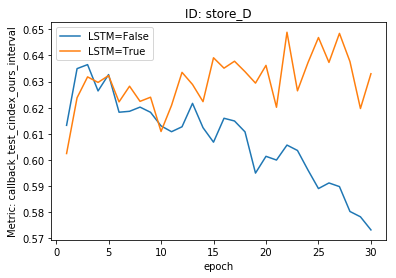

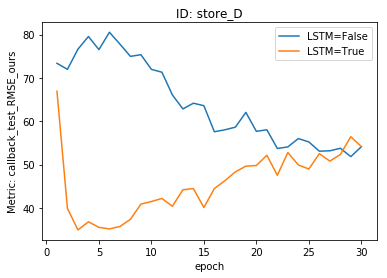

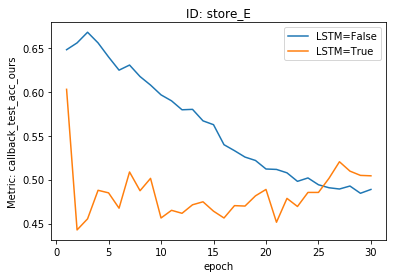

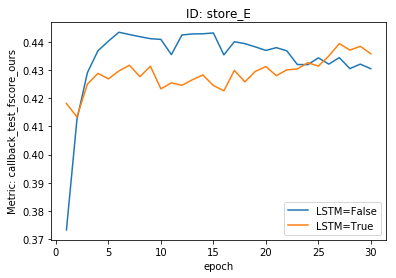

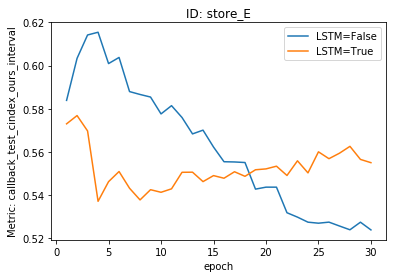

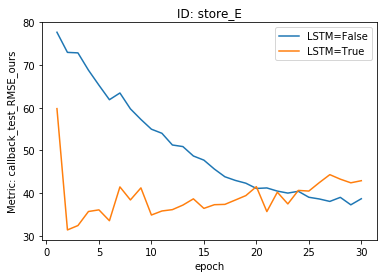

<Figure size 432x288 with 0 Axes>

In [5]:
store_ids = ['store_A', 'store_B', 'store_C', 'store_D', 'store_E']
metrics = ['callback_test_acc_ours', 'callback_test_fscore_ours', 'callback_test_cindex_ours_interval', 'callback_test_RMSE_ours']

for store_id in store_ids:
    for metric in metrics:
        try:
            draw_plot(store_id=store_id, metric=metric)
        except ValueError:
            pass
    

In [6]:
rslt_all.columns

Index(['exp_id', 'store_id', 'all_data', 'max_num_histories',
       'previous_visits', 'num_total_epoch', 'train_size', 'test_size',
       'train_censored_size', 'c_nll_date', 'c_nll_week', 'c_nll_month',
       'c_nll_season', 'c_rmse', 'c_ce', 'c_rank', 'time_start', 'time_end',
       'time_run', 'test_acc_majority_baseline', 'test_acc_xgb_baseline',
       'test_acc_cph_baseline', 'test_acc_ours',
       'test_fscore_majority_baseline', 'test_fscore_xgb_baseline',
       'test_fscore_cph_baseline', 'test_fscore_ours',
       'test_cindex_majority_baseline', 'test_cindex_xgb_baseline',
       'test_cindex_cph_baseline', 'test_cindex_ours_interval',
       'test_cindex_ours_censored_prob', 'test_RMSE_train_average_baseline',
       'test_RMSE_test_average_baseline', 'test_RMSE_xgb_baseline',
       'test_RMSE_cph_baseline', 'test_RMSE_ours',
       'train_censored_acc_majority_baseline',
       'train_censored_acc_xgb_baseline', 'train_censored_acc_cph_baseline',
       'train_cens

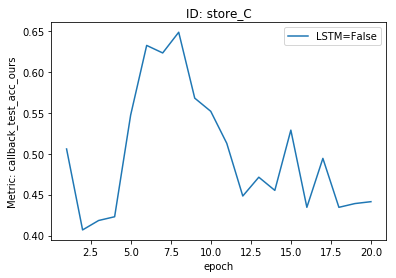

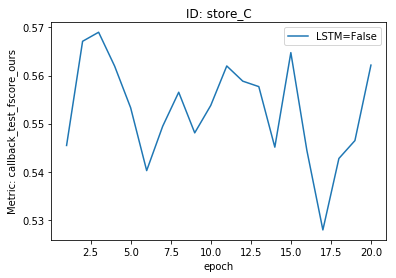

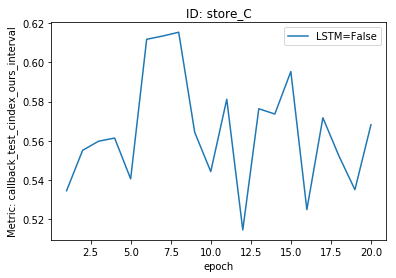

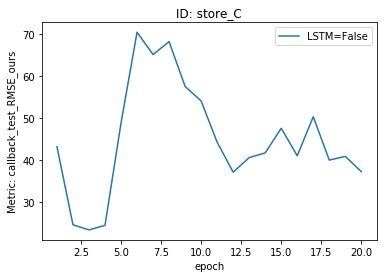

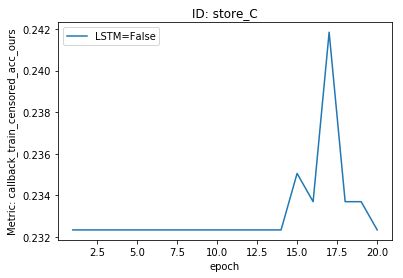

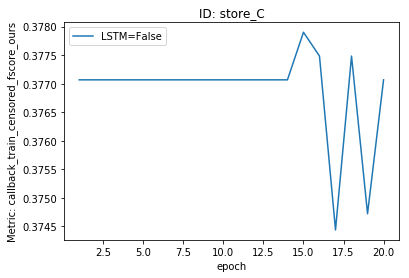

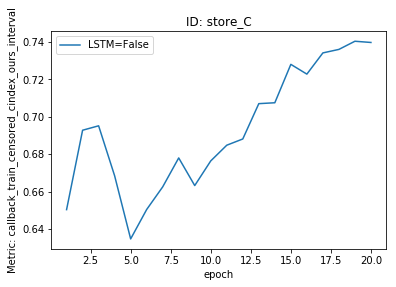

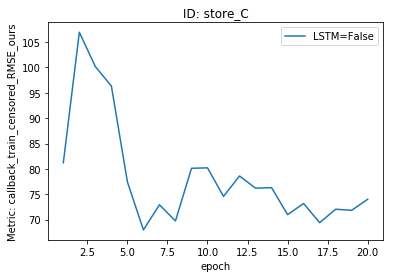

<Figure size 432x288 with 0 Axes>

In [13]:
## Check results for input exp IDs

def scorebyepoch(inputIDs, metric):
    """
    Parameter:
    inputIDs: ID to check
    metric: metric to check
    """
    file_true = ['../results/callback/{}.csv'.format(id) for id in inputIDs]
    dfl = []
    for cfile in file_true:
        rslt_cb = pd.read_csv(cfile)
        dfl.append(rslt_cb)
    rsltc = pd.concat(dfl)
    return rsltc.groupby(['epoch'])[metric].apply(np.mean)

def draw_plot_expID(expID, metric):
    scorebyepoch(expID, metric).plot()
    plt.title('ID: '+ store_id);
    plt.xlabel('epoch');
    plt.ylabel('Metric: {}'.format(metric));
    plt.legend(['LSTM=False', 'LSTM=True']);
    plt.figure(clear=True)

metrics = ['callback_test_acc_ours', 'callback_test_fscore_ours', 'callback_test_cindex_ours_interval', 'callback_test_RMSE_ours',
          'callback_train_censored_acc_ours', 'callback_train_censored_fscore_ours', 'callback_train_censored_cindex_ours_interval', 'callback_train_censored_RMSE_ours']
for metric in metrics:
    try:
        draw_plot_expID(expID=['7QIFBJ9F76'], metric=metric)
    except ValueError:
        pass
    
    

### Loss ratio

```Index(['exp_id', 'store_id', 'all_data', 'num_total_epoch', 'epoch', 'loss',
       'uc_c_loss_ce', 'uc_c_loss_rank', 'uc_loss_nll_date',
       'uc_loss_nll_month', 'uc_loss_nll_season', 'uc_loss_nll_week',
       'uc_loss_rmse', 'time_epoch', 'callback_test_acc_ours',
       'callback_test_fscore_ours', 'callback_test_cindex_ours_interval',
       'callback_test_RMSE_ours', 'callback_train_censored_acc_ours',
       'callback_train_censored_fscore_ours',
       'callback_train_censored_cindex_ours_interval',
       'callback_train_censored_RMSE_ours'],
       ```

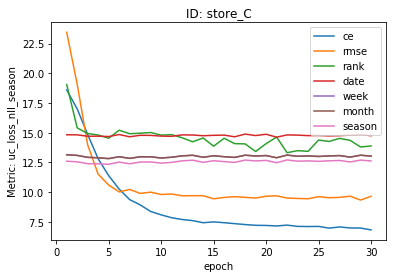

In [7]:
def getID(store_id, previous_visits, all_data=False):
    ids = set(rslt_all[(rslt_all.all_data == all_data) & (rslt_all.store_id == store_id) & (rslt_all.previous_visits == previous_visits)].exp_id)
    return ids

def scorebyepoch(inputIDs, metric, weight):
    """
    Parameter:
    inputIDs: ID to check
    metric: metric to check
    """
    file_true = ['../results/callback/{}.csv'.format(id) for id in inputIDs]
    dfl = []
    for cfile in file_true:
        rslt_cb = pd.read_csv(cfile)
#         print(rslt_cb.columns)
        dfl.append(rslt_cb)
    rsltc = pd.concat(dfl)
    return rsltc.groupby(['epoch'])[metric].apply(np.mean)*weight

def draw_plot(store_id, previous_visits, metric, weight):
    ID = getID(store_id=store_id,previous_visits=previous_visits,all_data=False)
    
    scorebyepoch(ID, metric, weight).plot()
#     scorebyepoch(trueID, metric).plot()
#     plt.xticks([0,5,10,15,20,25])
    plt.title('ID: '+ store_id);
    plt.xlabel('epoch');
    plt.ylabel('Metric: {}'.format(metric));
    plt.legend(['ce', 'rmse', 'rank', 'date', 'week', 'month', 'season']);
#     plt.figure(clear=True)

store_id = 'store_C'
previous_visits = False

# draw_plot(store_id=store_id, previous_visits=previous_visits, metric='loss', weight=0.2)
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_c_loss_ce', weight=20/64 )
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_loss_rmse', weight=20/64 ) 
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_c_loss_rank', weight=20/64)
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_loss_nll_date', weight=1/64 )
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_loss_nll_week', weight=1/64 )
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_loss_nll_month', weight=1/64 )
draw_plot(store_id=store_id, previous_visits=previous_visits, metric='uc_loss_nll_season', weight=1/64 )


In [16]:
list(pd.read_csv('../results/all/all_results.csv').columns)

['exp_id',
 'store_id',
 'all_data',
 'max_num_histories',
 'previous_visits',
 'num_total_epoch',
 'train_size',
 'test_size',
 'train_censored_size',
 'c_nll_date',
 'c_nll_week',
 'c_nll_month',
 'c_nll_season',
 'c_rmse',
 'c_ce',
 'c_rank',
 'time_start',
 'time_end',
 'time_run',
 'test_acc_majority_baseline',
 'test_acc_xgb_baseline',
 'test_acc_cph_baseline',
 'test_acc_ours',
 'test_fscore_majority_baseline',
 'test_fscore_xgb_baseline',
 'test_fscore_cph_baseline',
 'test_fscore_ours',
 'test_cindex_majority_baseline',
 'test_cindex_xgb_baseline',
 'test_cindex_cph_baseline',
 'test_cindex_ours_interval',
 'test_cindex_ours_censored_prob',
 'test_RMSE_train_average_baseline',
 'test_RMSE_test_average_baseline',
 'test_RMSE_xgb_baseline',
 'test_RMSE_cph_baseline',
 'test_RMSE_ours',
 'train_censored_acc_majority_baseline',
 'train_censored_acc_xgb_baseline',
 'train_censored_acc_cph_baseline',
 'train_censored_acc_ours',
 'train_censored_fscore_majority_baseline',
 'train_cen